In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import re
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

font_path = './malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
cafe = pd.read_csv('./result/구별 카페.csv', sep=',')
rest = pd.read_csv('./result/구별 한식점.csv', sep=',')
missing = pd.read_csv('./result/자치구 요일별 신고건수.csv', sep=',')
l_store = pd.read_csv('./result/구별 대규모점포.csv', sep=',')
유원지 = pd.read_csv('./result/구별 유원시설.csv', sep=',')
pop = pd.read_csv('./result/자치구 요일별 총생활인구.csv', sep=',')
park = pd.read_csv('./result/구별 공원개수.csv', sep=',')
liv_pop = pd.read_csv('./result/구별 거주인구.csv', sep=',')

In [ ]:
df = pd.merge(cafe, rest, on='자치구', how='outer')
df = pd.merge(df, missing, on='자치구', how='outer')
df = pd.merge(df, l_store, on='자치구', how='outer')
df = pd.merge(df, 유원지, on='자치구', how='outer')
df = pd.merge(df, pop, on=['자치구', 'day'], how='outer')
df = pd.merge(df, park, on='자치구', how='outer')
df = pd.merge(df, liv_pop, on='자치구', how='outer')

In [ ]:
df.fillna(0, inplace=True)

## try2

In [ ]:
df.drop('day', axis=1, inplace=True)

In [ ]:
df.columns

Index(['자치구', '카페 개수', '한식점 개수', '신고건수', '대규모점포', '유원시설', '시군구코드', '총생활인구수',
       '10세미만생활인구', '공원개수', '인구'],
      dtype='object')

In [ ]:
df = df[['자치구', '카페 개수', '한식점 개수', '대규모점포', '유원시설','총생활인구수', '10세미만생활인구', '공원개수', '인구', '신고건수']]

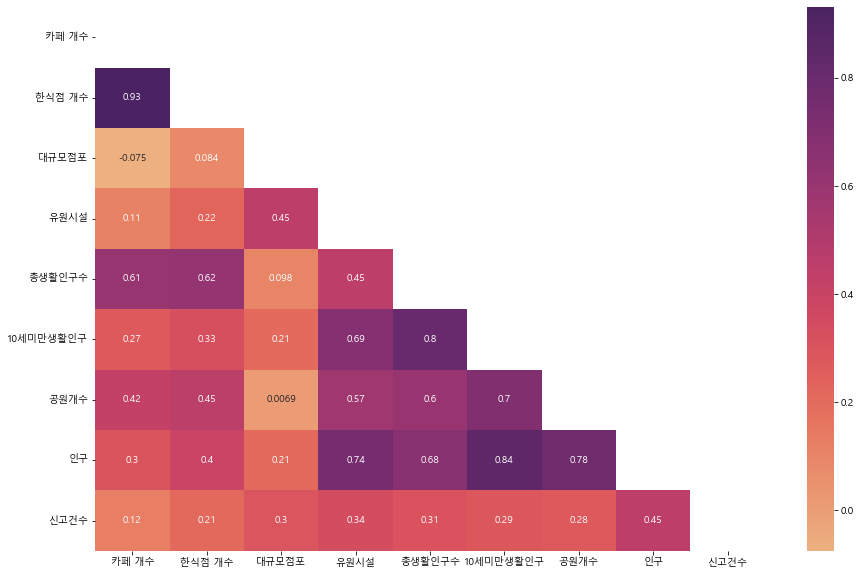

In [ ]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, mask=mask, cmap='flare')
plt.savefig('./result/heatmap.png')

In [ ]:
df.shape

(175, 10)

In [ ]:
df.describe()

,카페 개수,한식점 개수,대규모점포,유원시설,총생활인구수,10세미만생활인구,공원개수,인구,신고건수
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,809.405714,1317.765714,2.862857,9.051429,24176.822923,1589.744375,75.440000,390634.760000,10.822857
std,430.764024,620.230192,1.753008,4.621624,4603.057264,476.993792,39.208045,123821.887286,6.165117
min,0.000000,0.000000,0.000000,0.000000,12124.668298,500.312575,38.000000,131943.000000,0.000000
25%,550.000000,945.000000,2.000000,6.000000,21242.949418,1364.341298,48.000000,316415.000000,6.000000
50%,731.000000,1237.000000,3.000000,9.000000,24519.245995,1594.204216,54.000000,396122.000000,10.000000
75%,1052.000000,1439.000000,4.000000,11.000000,26779.051741,2024.439856,96.000000,467997.000000,14.000000
max,2385.000000,3344.000000,7.000000,22.000000,38539.370091,2254.267617,174.000000,664996.000000,29.000000


## KNN Regressor

In [13]:
X = df[df.columns[1:-1]]
y = df[['신고건수']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=123)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [14]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(X_scaled_train, y_train)
pred_train = model.predict(X_scaled_train)
print('Model TrainSet Score: ', model.score(X_scaled_train, y_train))

Model TrainSet Score:  0.6961742605338408


In [15]:
pred_test = model.predict(X_scaled_test)
print('Model TestSet Score: ', model.score(X_scaled_test, y_test))

Model TestSet Score:  0.5625226066157167


In [16]:
from sklearn.metrics import mean_squared_error
MSE_train = mean_squared_error(y_train, pred_train)
MSE_test = mean_squared_error(y_test, pred_test)
print('TrainSet RMSE: ', np.sqrt(MSE_train), ', TestSet RMSE: ', np.sqrt(MSE_test))

TrainSet RMSE:  3.306276601882073 , TestSet RMSE:  4.8108673276701825


In [17]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11]}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
grid_search.fit(X_scaled_train, y_train)

print("Best Parameter: {}".format(grid_search.best_params_))
print("Best Score: {:.4f}".format(grid_search.best_score_))
print("TestSet Score: {:.4f}".format(grid_search.score(X_scaled_test, y_test)))

Best Parameter: {'n_neighbors': 5}
Best Score: 0.4419
TestSet Score: 0.5625


In [19]:
cafe = pd.read_csv('./result/구별 카페.csv', sep=',')
rest = pd.read_csv('./result/구별 한식점.csv', sep=',')
missing = pd.read_csv('./result/자치구 요일별 신고건수.csv', sep=',')
l_store = pd.read_csv('./result/구별 대규모점포.csv', sep=',')
유원지 = pd.read_csv('./result/구별 유원시설.csv', sep=',')
pop = pd.read_csv('./result/자치구 요일별 총생활인구_test.csv', sep=',')
park = pd.read_csv('./result/구별 공원개수.csv', sep=',')
liv_pop = pd.read_csv('./result/구별 거주인구.csv', sep=',')

In [20]:
df = pd.merge(cafe, rest, on='자치구', how='outer')
df = pd.merge(df, missing, on='자치구', how='outer')
df = pd.merge(df, l_store, on='자치구', how='outer')
df = pd.merge(df, 유원지, on='자치구', how='outer')
df = pd.merge(df, pop, on=['자치구', 'day'], how='outer')
df = pd.merge(df, park, on='자치구', how='outer')
df = pd.merge(df, liv_pop, on='자치구', how='outer')

In [21]:
df.fillna(0, inplace=True)

In [22]:
df.drop('day', axis=1, inplace=True)

In [29]:
X = df[['자치구', '카페 개수', '한식점 개수', '대규모점포', '유원시설','총생활인구수', '10세미만생활인구', '공원개수', '인구']]

In [31]:
X_scaled = scaler.transform(X[X.columns[1:]])

In [32]:
pred_result = model.predict(X_scaled)

In [34]:
X['pred'] = pred_result

In [37]:
X_result = X.groupby('자치구')[['pred']].sum().reset_index()

In [42]:
X_result['result'] = X_result['pred'] /(X_result['pred']).sum() * 100

In [47]:
X_result.sort_values(by='result', ascending=False, inplace=True)

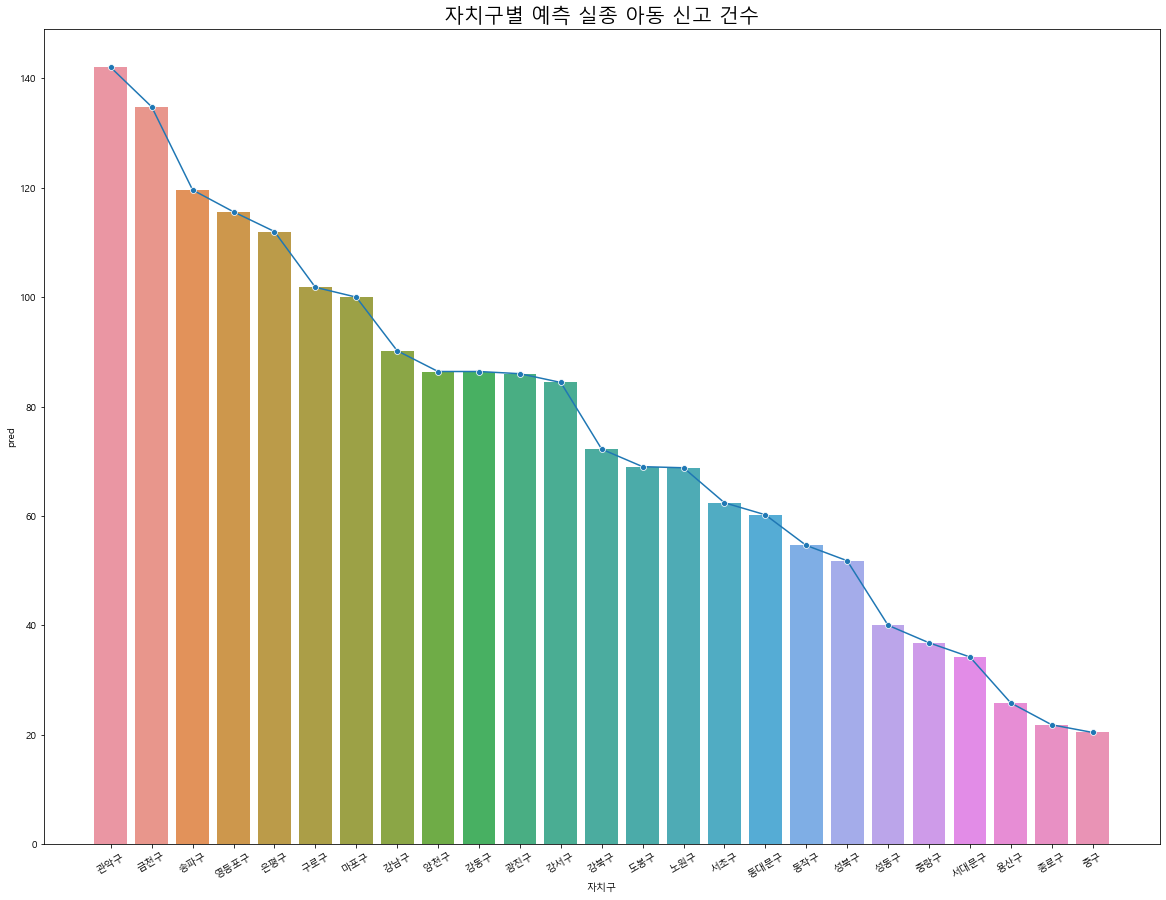

In [51]:
plt.figure(figsize=(20, 15))
p = sns.barplot(x='자치구', y='pred', data=X_result)
sns.lineplot(x='자치구', y='pred', data=X_result, marker='o')
p.set_title('자치구별 예측 실종 아동 신고 건수', fontsize=20)
plt.xticks(rotation=30)
plt.savefig('./result/자치구별 예측 실종 아동 신고 건수.png')
plt.show()